## Objective

Predicting total sales for every product and store in the next month for a time series dataset consisting of daily sales data.

My analysis pipeline:

- Combine the data and count total sales for every month for every shop every item for 2013/01 - 2015/10.

- How to deal with shop id, item id and month - Label Encoding.

- Scale the item price and monthly sales.

- Split training dataset into a 7/3 for train/test data with CV=5.

- Train the baseline model - linear regression and then random forest and XGBT.

- Choose best model and tune hyperparameters (maybe future work).

- Predict Nov total sales and fill out the test csv.

- Conclusion and recommendations.

## Import libary

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
from math import sqrt
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Exploratory data analyses (EDA)

### Load data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
path_1 = '/content/drive/My Drive/Kaggle/sales_train.csv'
path_2 = '/content/drive/My Drive/Kaggle/test.csv'
path_3 = '/content/drive/My Drive/Kaggle/shops.csv'
path_4 = '/content/drive/My Drive/Kaggle/item_categories.csv'
path_5 = '/content/drive/My Drive/Kaggle/items.csv'
sales_train = pd.read_csv(path_1)
test_data = pd.read_csv(path_2)
shops_data = pd.read_csv(path_3)
item_categories = pd.read_csv(path_4)
items = pd.read_csv(path_5)

### Data overview

In [0]:
print(sales_train.shape, test_data.shape, shops_data.shape, item_categories.shape, items.shape)

(2935849, 6) (214200, 3) (60, 2) (84, 2) (22170, 3)


In [0]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [0]:
sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [0]:
sales_train.tail(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [0]:
# count the distint value
print(sales_train.date_block_num.nunique(), sales_train.shop_id.nunique(), sales_train.item_id.nunique())

34 60 21807


In [0]:
# count the duplicates
print(sales_train.duplicated().sum())

6


In [0]:
sales_train.date[0] # date here is a string

'02.01.2013'

Need to convert the date column into datetime, which is string to datetime.

In [0]:
sales_train.date = pd.to_datetime(sales_train.date, format='%d.%m.%Y')

In [0]:
sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


In [0]:
# check null value
print(sales_train.isnull().sum())

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


In [0]:
# check item_cnt_day
sales_train.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [0]:
# check item price
sales_train.item_price.describe()

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

It can be seen the item_cnt_day which is the target to predict can be negative, may be this product is returned.

Also the date_block_num for Janurary is 0, which means Janurary is the reference month in this dataset.

Therefore for prediction sales in November, the date_block_num will be 34.

In [0]:
test_data.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [0]:
test_data = test_data.drop(['ID'], axis=1)

In [0]:
shops_data.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [0]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [0]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


The attributes in training data and test data may be enough to predict , the item category name, category id and item name may be unnecessary while modelling because they do not show up on the test data.

### Visualize numerical features

In [0]:
sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0
2,2013-01-05,0,25,2552,899.0,-1.0


#### How the price distribute

In [0]:
sns.set(style='whitegrid', font_scale=1.1, rc={'figure.figsize': [6, 4]})

[Text(0.5, 1.0, 'Price distribution')]

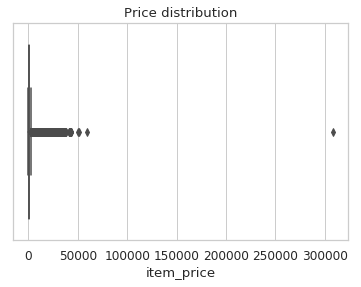

In [0]:
sns.boxplot(sales_train['item_price']).set(title='Price distribution')

There are item price under zero. I will fill this item negative price with this item's median.

In [0]:
sales_train[sales_train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [0]:
sales_train.iloc[484683, 4] = sales_train[sales_train['item_id'] == 2973].item_price.median()

#### How the daily sales distribute

[Text(0.5, 1.0, 'Daily sale distribution')]

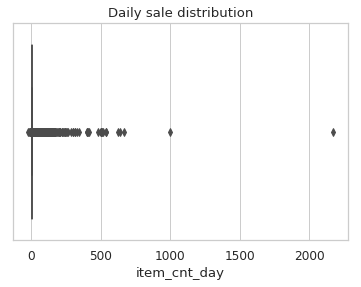

In [0]:
sns.boxplot(sales_train['item_cnt_day']).set(title='Daily sale distribution')

In [0]:
sales_train[sales_train['item_cnt_day'] > 500].sort_values(['item_cnt_day'], axis=0, ascending=False)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169.0
2326930,2015-01-15,24,12,20949,4.000000,1000.0
2864235,2015-09-30,32,12,9248,1692.526158,669.0
2851091,2015-09-30,32,55,9249,1702.825746,637.0
2608040,2015-04-14,27,12,3731,1904.548077,624.0
2626181,2015-05-19,28,12,11373,155.192950,539.0
2851073,2015-09-29,32,55,9249,1500.000000,533.0
2048518,2014-10-02,21,12,9242,1500.000000,512.0
2067669,2014-10-09,21,55,19437,899.000000,508.0
2864260,2015-09-29,32,12,9248,1500.000000,504.0


Those are very excellent daily sales. The success maily is because of the lower price. The popular shops id are 12 and 55.

#### Relation between features in pairs

Now combine the daily sale for monthly use for each shop, each item, each month starting from 2013 to 2015.

This dataset will be used in the data modelling.

In [0]:
sales_detail = sales_train \
.groupby(['date_block_num','shop_id','item_id'])['item_price','item_cnt_day'] \
.agg({'item_price':'mean','item_cnt_day':'sum'}) \
.reset_index() \
.rename(columns={'item_cnt_day': 'item_cnt_month'})

In [0]:
sales_detail.head(3)

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,0,32,221.0,6.0
1,0,0,33,347.0,3.0
2,0,0,35,247.0,1.0


##### 1. Sales trend monthly

In [0]:
sales_time = sales_detail \
.groupby(['date_block_num'])['item_cnt_month'].sum() \
.reset_index()
sales_time.head(3)

,date_block_num,item_cnt_month
0,0,131479.0
1,1,128090.0
2,2,147142.0


[Text(0, 0.5, 'monthly sales'),
 Text(0.5, 0, 'consecutive month'),
 Text(0.5, 1.0, 'Sales change with month')]

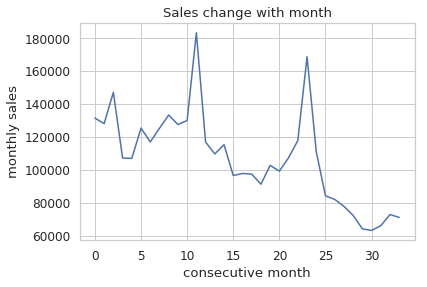

In [0]:
sns.lineplot(x='date_block_num', y='item_cnt_month', data=sales_time) \
.set(xlabel='consecutive month', ylabel='monthly sales', title='Sales change with month')

Here we can see at the end of each year, the sales come to a peak value, also a small jump in summer, may be due to the summer sale and winter sale. It means we should increase our supply around Nov and Dec.

Also the monly sales decrease per year, which means we should figure out why our items not attracting.

##### 2. Shop popularity trend monthly

In [0]:
sales_shop = sales_detail \
.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].sum() \
.reset_index()
sales_shop.head(3)

,date_block_num,shop_id,item_cnt_month
0,0,0,5578.0
1,0,1,2947.0
2,0,2,1146.0


[Text(0, 0.5, 'monthly sale'),
 Text(0.5, 0, 'consecutive month'),
 Text(0.5, 1.0, 'monthly sales per shop')]

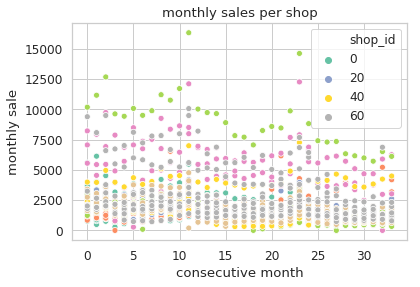

In [0]:
sns.scatterplot(x='date_block_num', y='item_cnt_month', hue='shop_id', data=sales_shop, palette='Set2', legend='brief') \
.set(xlabel='consecutive month', ylabel='monthly sale', title='monthly sales per shop')

From the scatterplot,there can be seen lower shop id have better performance, especially shops from 20 to 40. Shops with higher id have relatively worse performance. Now let's specificly see which shops do better on sales. Top 10 best shops id are determined below. For detail, can go to the shop dataset to find those shops' names.

In [0]:
top_shop_id = sales_shop.sort_values(['item_cnt_month'], axis=0, ascending=False)['shop_id'].unique()[:10]

In [0]:
# top 10 (ranking) shop id
top_shop_id

array([31, 25, 54, 57, 28, 27, 42, 55,  9,  0])

In [0]:
# top 10 (no ranking) shop name
shops_data[shops_data['shop_id'].isin(top_shop_id)].shop_name

0       !Якутск Орджоникидзе, 56 фран
9                   Выездная Торговля
25                Москва ТРК "Атриум"
27     Москва ТЦ "МЕГА Белая Дача II"
28    Москва ТЦ "МЕГА Теплый Стан" II
31            Москва ТЦ "Семеновский"
42             СПб ТК "Невский Центр"
54                    Химки ТЦ "Мега"
55           Цифровой склад 1С-Онлайн
57            Якутск Орджоникидзе, 56
Name: shop_name, dtype: object

##### 3. Item popularity trend monthly

In [0]:
sales_item = sales_detail \
.groupby(['date_block_num', 'item_id'])['item_cnt_month'].sum() \
.reset_index()
sales_item.head(3)

,date_block_num,item_id,item_cnt_month
0,0,19,1.0
1,0,27,7.0
2,0,28,8.0


[Text(0, 0.5, 'monthly sale'),
 Text(0.5, 0, 'consecutive month'),
 Text(0.5, 1.0, 'monthly sales per item')]

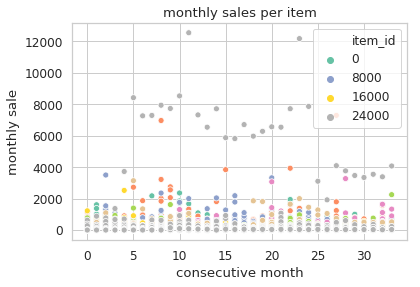

In [0]:
sns.scatterplot(x='date_block_num', y='item_cnt_month', hue='item_id', data=sales_item, palette='Set2', legend='brief') \
.set(xlabel='consecutive month', ylabel='monthly sale', title='monthly sales per item')

Items with higher id have relatively better performance. Now let's specificly see which items do better on sales. Top 10 best items id are determined below. For detail, can go to the item dataset to find those items' names.

In [0]:
top_item_id = sales_item.sort_values(['item_cnt_month'], axis=0, ascending=False)['item_id'].unique()[:10]

In [0]:
# top 10 (with ranking) item id
top_item_id

array([20949,  3731,  3732,  3733,  2814,  6738,  6502, 10210, 10209,
        3734])

In [0]:
# top 10 (without ranking) item names
items[items['item_id'].isin(top_item_id)].item_name

2814     Diablo III: Reaper of Souls (дополнение) [PC, ...
3731             Grand Theft Auto V [PC, русские субтитры]
3732            Grand Theft Auto V [PS3, русские субтитры]
3733            Grand Theft Auto V [PS4, русские субтитры]
3734       Grand Theft Auto V [Xbox 360, русские субтитры]
6502           Sims 4 Limited Edition [PC, русская версия]
6738     StarCraft II: Heart of the Swarm (дополнение) ...
10209          Ведьмак 3: Дикая охота [PC, русская версия]
10210         Ведьмак 3: Дикая охота [PS4, русская версия]
20949    Фирменный пакет майка 1С Интерес белый (34*42)...
Name: item_name, dtype: object

The most popular items are electronic devices like PC and PS3, PS4, etc. Top brands are Grand Theft Auto V and Дикая охота.

## Data modelling

Although shop id, item id and month are shown as numerics, they should be treated as categorical features, because they do not have difference between each other no matter the value is low or high. However, due to the very huge dataset, one-hot encoding will cause crash. For now I just use label encoding, which the performance might be not as good as one-hot encoding.

I will treat this forcasting problem as a regression problem, therefore, I will choose several regressor model, baseline is linear regression, then advanced model like random forest and GBT see if they will outperform. Because it is a regression model, I will select R2 score as measure metric, R2 score score can describe overall fit performance.

### Label encoding

In [0]:
mon_le = LabelEncoder()
shop_le = LabelEncoder()
item_le = LabelEncoder()
sales_detail['month_id'] = mon_le.fit_transform(sales_detail['date_block_num'])
sales_detail['shop_id'] = shop_le.fit_transform(sales_detail['shop_id'])
sales_detail['item_id'] = item_le.fit_transform(sales_detail['item_id'])
sales_detail = sales_detail.drop(['date_block_num'], axis = 1)

In [0]:
sales_detail.head(3)

,shop_id,item_id,item_price,item_cnt_month,month_id
0,0,32,221.0,6.0,0
1,0,33,347.0,3.0,0
2,0,35,247.0,1.0,0


### Scaler

Scale the item price and item_cnt_month because there are a few extreme high values that can be seen in the boxlot before. It will affect our model accuracy if not removed.

In [0]:
price_scaler = StandardScaler()
count_scaler = StandardScaler()

price_scaler.fit(sales_detail.item_price.values.reshape(-1, 1))
count_scaler.fit(sales_detail.item_cnt_month.values.reshape(-1, 1))

sales_detail.item_price = price_scaler.transform(sales_detail.item_price.values.reshape(-1, 1))
sales_detail.item_cnt_month = count_scaler.transform(sales_detail.item_cnt_month.values.reshape(-1, 1))

In [0]:
sales_detail.head(3)

,shop_id,item_id,item_price,item_cnt_month,month_id
0,0,32,-0.367288,0.431544,0
1,0,33,-0.286081,0.084718,0
2,0,35,-0.350531,-0.146499,0


### Split data

In [0]:
y = sales_detail[['item_cnt_month']]
X = sales_detail.drop(['item_cnt_month'], axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1126386, 4) (1126386, 1) (482738, 4) (482738, 1)


### Fit the model

#### 1. linear model

In [0]:
lr = linear_model.LinearRegression()
lr_fitted = lr.fit(X_train, y_train)
lr_prediction = lr_fitted.predict(X_test)
r2_score(y_test, lr_prediction)

0.0006769972427118631

The linear regression seems very bad.

#### 2. Random forest

In [0]:
rf = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=200)
rf_fitted = rf.fit(X_train, y_train)
rf_prediction = rf_fitted.predict(X_test)
r2_score(y_test, rf_prediction)

0.5196482128358482

Random forest is much more better than linear regression, but not good enough.

In [0]:
feature = {'feature':list(X.columns.values), 'importance':rf_fitted.feature_importances_}
feaure_importance = pd.DataFrame(feature).sort_values(['importance'], ascending=False)

[Text(0, 0.5, 'importance_%'),
 Text(0.5, 0, 'feature name'),
 Text(0.5, 1.0, 'feature importance')]

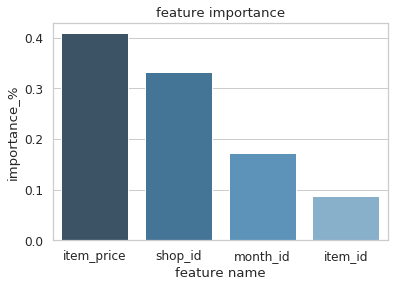

In [0]:
sns.barplot(x='feature', y='importance', data=feaure_importance, orient='v', palette='Blues_d') \
.set(xlabel='feature name', ylabel='importance_%', title='feature importance')

#### 3. XGBT

In [0]:
bt = GradientBoostingRegressor(n_estimators=200, max_depth=10)
bt_fitted = bt.fit(X_train, y_train)
bt_prediction = bt_fitted.predict(X_test)
r2_score(y_test, bt_prediction)

0.6242583281119303

XGBT is the best among those models and reaches lowest R2 score.

In [0]:
feature_bt = {'feature':list(X.columns.values), 'importance':bt_fitted.feature_importances_}
feaure_importance_bt = pd.DataFrame(feature_bt).sort_values(['importance'], ascending=False)

[Text(0, 0.5, 'importance'),
 Text(0.5, 0, 'feature name'),
 Text(0.5, 1.0, 'feature importance')]

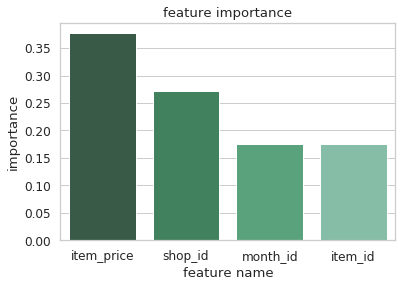

In [0]:
sns.barplot(x='feature', y='importance', data=feaure_importance_bt, orient='v', palette='BuGn_d') \
.set(xlabel='feature name', ylabel='importance', title='feature importance')

Here we can see the price is much more crucial to customers, which is nearly a half. Second, shop is kind of important, maybe the shops located at downtown are bigger and more popular because the items are more various and customers are more well-serviced. Time is somewhat relative, remember findings before about peak in winter.

## Finish forcasting

Noting: It can be found that in our training data, the price for the same item in different shops may differ from different months. To avoid huge duplicates when finding the price for our test item for different shops, I assume they have the same price for one item in one shop in Nov 2015, using the mean price extracted for months before.

In [0]:
sales_price = sales_detail \
.groupby(['shop_id', 'item_id'])['item_price'].mean() \
.reset_index()
sales_price.head(3)

,shop_id,item_id,item_price
0,0,30,-0.338930
1,0,31,-0.230010
2,0,32,-0.367288


In [0]:
test_data['month_id'] = 34
test_data['item_cnt_month'] = 0
test_data.head(3)

,shop_id,item_id,month_id,item_cnt_month
0,5,5037,34,0
1,5,5320,34,0
2,5,5233,34,0


In [0]:
test_new = test_data.merge(sales_price, left_on=['item_id','shop_id'], right_on = ['item_id','shop_id'], how='left').reset_index()

In [0]:
test_new.head(3)

,index,shop_id,item_id,month_id,item_cnt_month,item_price
0,0,5,5037,34,0,NaN
1,1,5,5320,34,0,NaN
2,2,5,5233,34,0,-0.317017


In [0]:
percentage = test_new.item_price.isnull().sum()/test_new.shape[0]
print('There are', round(percentage*100, 2), '% of all the test data do not have information in our training data')

There are 63.74 % of all the test data do not have information in our training data


There are a lot of items have not ever been saled in some shops. Therefore, cannot determine the price for that item in that shop, just use mean price in other shops to fill the NA.

In [0]:
test_new['item_price'] = test_new.groupby('item_id')['item_price'].transform(lambda group: group.fillna(group.mean()))

In [0]:
test_new = test_new.drop(['index'], axis=1)

In [0]:
test_new.shape

(214200, 5)

In [0]:
test_new.head(3)

,shop_id,item_id,month_id,item_cnt_month,item_price
0,5,5037,34,0,-0.284792
1,5,5320,34,0,0.660036
2,5,5233,34,0,-0.317017


In [0]:
print(test_new.isnull().sum())

shop_id               0
item_id               0
month_id              0
item_cnt_month        0
item_price        11130
dtype: int64


There are still some item only sale in that shop but does not have price information, I will use median of entire test data to fill.

In [0]:
test_new['item_price'] = test_new['item_price'].fillna(test_new['item_price'].median())

In [0]:
test_new.head(3)

,shop_id,item_id,month_id,item_cnt_month,item_price
0,5,5037,34,0,-0.284792
1,5,5320,34,0,0.660036
2,5,5233,34,0,-0.317017


In [0]:
print(test_new.isnull().sum())

shop_id           0
item_id           0
month_id          0
item_cnt_month    0
item_price        0
dtype: int64


In [0]:
X_fill = test_new[['shop_id', 'item_id', 'item_price', 'month_id']]
test_new['item_cnt_month'] = bt_fitted.predict(X_fill)

In [0]:
test_new['item_cnt_month'] = np.round(count_scaler.inverse_transform(test_new['item_cnt_month']))
test_new['item_price'] = np.round(price_scaler.inverse_transform(test_new['item_price']))

In [0]:
export_csv = test_new.to_csv ('/content/drive/My Drive/Kaggle/forcasting.csv', index=None, header=True)

## Explore forcasting data

### Top sale shop names

In [0]:
path_new = '/content/drive/My Drive/Kaggle/forcasting.csv'

In [0]:
new_data = pd.read_csv(path_new)

In [0]:
new_data.head(3)

,shop_id,item_id,month_id,item_cnt_month,item_price
0,5,5037,34,1.0,349.0
1,5,5320,34,1.0,1815.0
2,5,5233,34,1.0,299.0


In [0]:
df_shop = new_data \
.groupby(['shop_id'])['item_cnt_month'].sum() \
.reset_index()
df_shop.head(3)

,shop_id,item_cnt_month
0,2,11857.0
1,3,11486.0
2,4,11799.0


[Text(0, 0.5, 'Nov sales'),
 Text(0.5, 0, 'shop id'),
 Text(0.5, 1.0, 'Total sales in Nov per shop')]

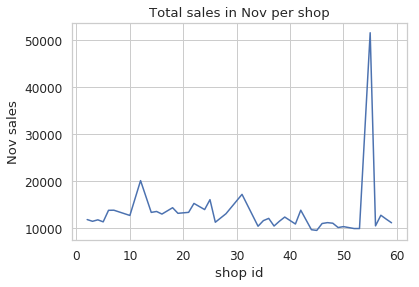

In [0]:
sns.lineplot(x='shop_id', y='item_cnt_month', data=df_shop) \
.set(xlabel='shop id', ylabel='Nov sales', title='Total sales in Nov per shop')

In [0]:
top_shops_id = df_shop.sort_values(['item_cnt_month'], axis=0, ascending=False)['shop_id'].unique()[:10]

In [0]:
# shops with highest sales (with ranking)
top_shops_id

array([55, 12, 31, 25, 22, 18, 24,  7, 42,  6])

In [0]:
# top shop names (without ranking)
shops_data[shops_data['shop_id'].isin(top_shops_id)].shop_name

6           Воронеж (Плехановская, 13)
7               Воронеж ТРЦ "Максимир"
12                 Интернет-магазин ЧС
18                Красноярск ТЦ "Июнь"
22                  Москва Магазин С21
24    Москва ТК "Буденовский" (пав.К7)
25                 Москва ТРК "Атриум"
31             Москва ТЦ "Семеновский"
42              СПб ТК "Невский Центр"
55            Цифровой склад 1С-Онлайн
Name: shop_name, dtype: object

Those shops will sale very well in next month.

### Top sale item name

In [0]:
df_item = new_data \
.groupby(['item_id'])['item_cnt_month'].sum() \
.reset_index()
df_item.head(3)

,item_id,item_cnt_month
0,30,74.0
1,31,178.0
2,32,75.0


[Text(0, 0.5, 'Nov sales'),
 Text(0.5, 0, 'item id'),
 Text(0.5, 1.0, 'Total sales in Nov per item')]

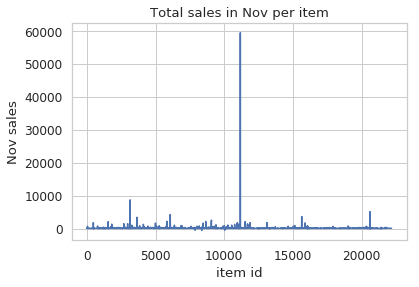

In [0]:
sns.lineplot(x='item_id', y='item_cnt_month', data=df_item) \
.set(xlabel='item id', ylabel='Nov sales', title='Total sales in Nov per item')

In [0]:
top_items_id = df_item.sort_values(['item_cnt_month'], axis=0, ascending=False)['item_id'].unique()[:10]

In [0]:
# items with highest sales (with ranking)
top_items_id

array([11170,  3156, 20602,  6073, 15635,  3651,  3652,  9066,  5827,
        8656])

In [0]:
# items with highest sales (without ranking)
items[items['item_id'].isin(top_items_id)].item_name

3156     ESET NOD32 Антивирус  продление лицензии  3 ПК...
3651                                      GUF  Город дорог
3652                                             GUF  Дома
5827                            Pokemon XY Двойной блистер
6073     Ratchet & Clank Trilogy [PS Vita, английская в...
8656                  БАРБОСКИНЫ  ЛУЧШИЕ СЕРИИ  1 (регион)
9066                      БУКАШКИ: БУКАШКИ КАРИБСКОГО МОРЯ
11170                 ДОМ С ПАРАНОРМАЛЬНЫМИ ЯВЛЕНИЯМИ (BD)
15635    НЕВЕРОЯТНЫЕ ПРИКЛЮЧЕНИЯ ИТАЛЬЯНЦЕВ В РОССИИ (р...
20602           Фигурка Marvel Universe Deadpool POP 3,75"
Name: item_name, dtype: object

## Conclusion

- XGBT has the best performance with a r2 score of 0.62, which is higher than random forest and linear regression.

- In the past two years, the total sales for all shops have decreased year by year, however, sales go to peak in winter, especially Nov and Dec. It means we should expand our quantity of production, but the reason for the total sale reduction should be further explored.

- The most 10 popular items are electrical devices.

- From feature imporce, we can see price and specific shop are biggest factors to drive customer buy items.

- After prediction the sales for next month, the total sales are better than last two years. Top popular items are games, toys, etc.

## Future work

- Better tune hyperparameters in XGBT with cross-validation.

- Feature engineering. Add some features about shop, time lag.

- Try time-series model like ARIMA.